In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [57]:
df = pd.read_csv("star_classification.csv")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [59]:
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']

In [60]:
X = df[['u-g', 'g-r', 'r-i', 'i-z', 'redshift']]
#X = df[['u-g', 'g-r', 'r-i', 'i-z', "alpha", "delta", "MJD", 'redshift']]

y = df['class']

In [61]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

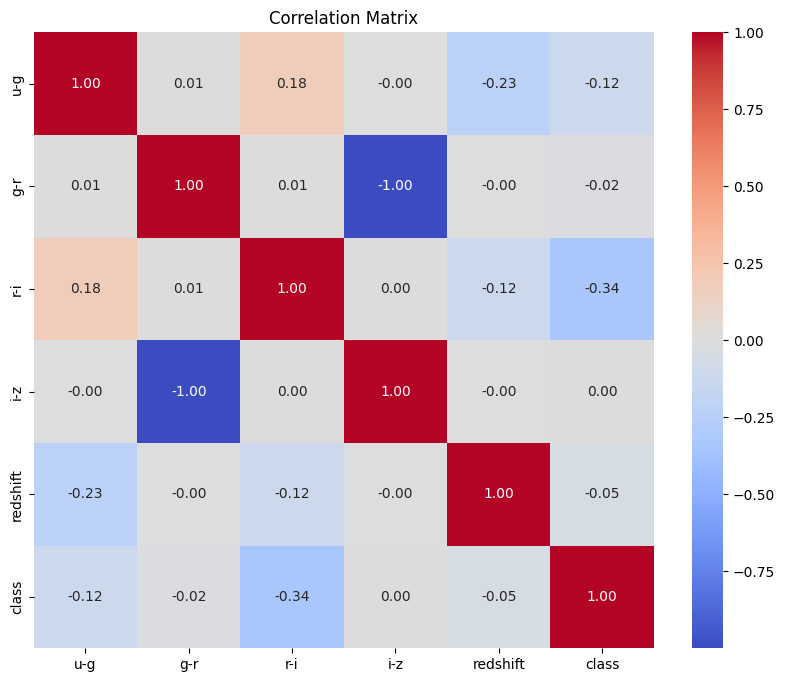

In [62]:
data_for_corr = X.copy()
data_for_corr['class'] = y_enc
# Compute correlation matrix

corr = data_for_corr.corr()# Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [63]:
# df.drop(columns=["i-z"], inplace=True)

In [64]:
# df.drop(columns=["g-r"], inplace=True)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train_scaled, y_train)

C:\Users\anton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [68]:
y_pred = lr.predict(X_test_scaled)

In [69]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9473

Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.96      0.95      0.96     17834
         QSO       0.93      0.87      0.90      5688
        STAR       0.94      1.00      0.97      6478

    accuracy                           0.95     30000
   macro avg       0.94      0.94      0.94     30000
weighted avg       0.95      0.95      0.95     30000



In [70]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None

    # Softmax function
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # Fit the model
    def fit(self, X, y):
        X = np.c_[np.ones((X.shape[0], 1)), X]  # add intercept
        self.classes_ = np.unique(y)
        K = len(self.classes_)
        m, n = X.shape
        self.theta = np.zeros((n, K))
        
        # One-hot encode y
        Y = np.zeros((m, K))
        for i, cls in enumerate(self.classes_):
            Y[:, i] = (y == cls).astype(int)

        # Gradient descent
        for _ in range(self.iterations):
            Z = X @ self.theta
            P = self._softmax(Z)
            gradient = X.T @ (P - Y) / m
            self.theta -= self.learning_rate * gradient

    # Predict probabilities
    def predict_proba(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]  # add intercept
        Z = X @ self.theta
        return self._softmax(Z)

    # Predict class labels
    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

In [71]:
model = MultinomialLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X_train, y_train)

In [72]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.8616

Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.87      0.91      0.89     17834
         QSO       0.92      0.88      0.90      5688
        STAR       0.79      0.71      0.75      6478

    accuracy                           0.86     30000
   macro avg       0.86      0.83      0.85     30000
weighted avg       0.86      0.86      0.86     30000



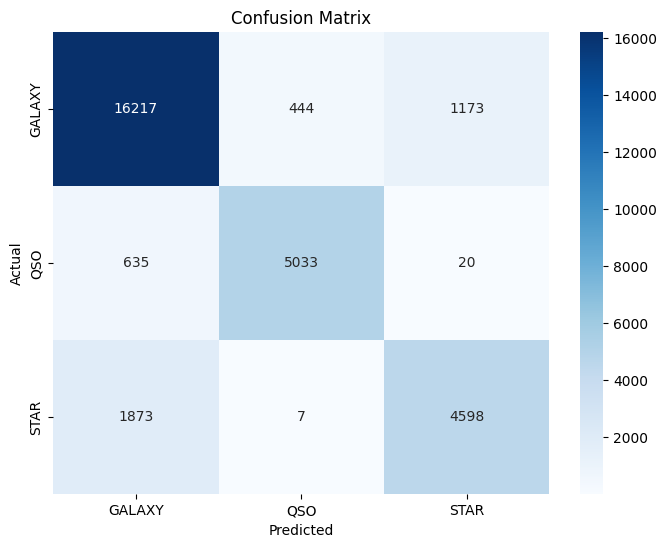

In [73]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()